In [2]:
import pandas as pd
import numpy as np
import pickle
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn import metrics
from sklearn import preprocessing
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

import warnings,os
warnings.simplefilter('ignore')

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 

#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 8, 5

path="C:\\Users\\Admin\\Documents\\"

C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
def CreateData(dataFrame):
    dataset =np.array( dataFrame.iloc[:, 0:1044])
    target = dataFrame.loc[:,['label']]
    target = np.array(target.replace(to_replace=['О', 'К'], value=[1, 0]))
    target =target.astype('int32')   
    target.transpose()
    x=np.where(np.isnan(dataset))[0]
    x=np.unique(x)
    i=0   
    for item in x:
        dataset=np.delete(dataset, item-i, axis=0)
        target=np.delete(target, item-i)
        i+=1
    return dataset,target

In [4]:
#сохранение
def saveModel(score,path,nameModel):
    save=False
    dateFile = os.listdir(path)
    name=path+ str(score)+'_'+nameModel+'.pkl'
    for item in dateFile:
        temp=item.split('_')
        if len(temp)==2:
            if (temp[1].find(nameModel)!=-1):
                if (float(temp[0])<score):
                    print("Модель",nameModel,"сохранена\n")
                    save=True
    return save,name

In [5]:
path="C:\\Users\\Admin\\Documents\\raman2.xlsx"
dataFrame = pd.read_excel(path)
path="C:\\Users\\Admin\\Documents\\PythonRaman\\"
x,y=CreateData(dataFrame)
train_dataset ,  test_dataset ,  train_target ,  test_target=train_test_split(x,y, test_size=0.30,stratify=y)
normalized_train_dataset = preprocessing.normalize(train_dataset)
normalized_test_dataset = preprocessing.normalize(test_dataset)

Дерево принятия решений

Fitting 5 folds for each of 150 candidates, totalling 750 fits


[Parallel(n_jobs=1)]: Done 750 out of 750 | elapsed:    7.3s finished


0.30466472303206993 7 17 

[[ 87  47]
 [ 47 114]]
f1ScoreWeighted= 0.6813559322033899
f1ScoreMacro= 0.6786641327523872
f1ScoreBinary= 0.7080745341614908
Модель cartModel сохранена



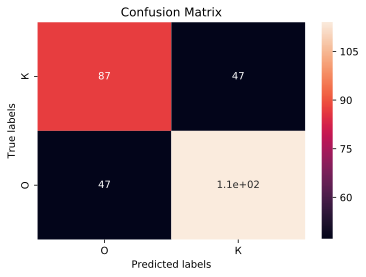

In [6]:
from sklearn.tree import DecisionTreeClassifier
#Cart
print("Дерево принятия решений\n")

#GridSearchCV
#----------------------------------------------------------------------
cartModel = DecisionTreeClassifier()
tuned_parameters = {'max_depth': np.arange(1,11),
                'max_features': np.arange(4,19)}
tree_grid = GridSearchCV(cartModel, tuned_parameters,cv=5, 
                         verbose=True)
tree_grid.fit(normalized_train_dataset, train_target)

best_parameter_max_depth = tree_grid.best_estimator_.max_depth
best_parameter_max_features = tree_grid.best_estimator_.max_features
best_cv_err = 1 - tree_grid.best_score_
print (best_cv_err, best_parameter_max_depth,best_parameter_max_features,"\n")
#----------------------------------------------------------------------
#Обучение модели с оптимальными параметрами
cartModel = DecisionTreeClassifier(max_depth=best_parameter_max_depth,
                                   max_features=best_parameter_max_features)
cartModel.fit(normalized_train_dataset, train_target)

#предсказание
expected = test_target
predicted = cartModel.predict(normalized_test_dataset)
#---------------------------------------------------------------------
#Отрисовка confusion_matrix
from sklearn.metrics import confusion_matrix

cm = metrics.confusion_matrix(expected, predicted)
print(cm)
import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['О', 'К']); 
ax.yaxis.set_ticklabels(['К','О']);
#--------------------------------------------------------------------

f1ScoreWeighted=f1_score(test_target, predicted, average='weighted')
print("f1ScoreWeighted=",f1ScoreWeighted)

f1ScoreMacro=f1_score(test_target, predicted, average='macro')
print("f1ScoreMacro=",f1ScoreMacro)

f1ScoreBinary=f1_score(test_target, predicted, average='binary')
print("f1ScoreBinary=",f1ScoreBinary)

Score=[f1ScoreBinary]
NameModel=["cartModel"]
save,name=saveModel(Score[0],path,NameModel[0])

if save==True:
    with open(name, 'wb') as fid:
        pickle.dump(cartModel, fid)

Логическая регрессия

0.3702623906705539 141 

[[ 93  41]
 [ 55 106]]
f1ScoreWeighted= 0.6752581713274105
f1ScoreMacro= 0.6739430781983974
f1ScoreBinary= 0.6883116883116883


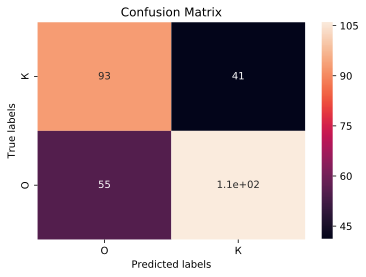

In [7]:
from sklearn.linear_model import LogisticRegression
#Логическая регрессия
print("Логическая регрессия\n")


#GridSearchCV
#----------------------------------------------------------------------
tuned_parameters = {'C': list(range(1,150))}
grid = GridSearchCV(LogisticRegression(solver='liblinear'), tuned_parameters, 
                   cv=5, scoring="accuracy")
grid.fit(normalized_train_dataset, train_target)

best_cv_err2 = 1 - grid.best_score_
best_parameter = grid.best_estimator_.C
print (best_cv_err2, best_parameter,"\n")
#----------------------------------------------------------------------
#Обучение модели с оптимальными параметрами
lgModel = LogisticRegression(C=best_parameter)
lgModel.fit(normalized_train_dataset, train_target)

expected = test_target
predicted = lgModel.predict(normalized_test_dataset)

#---------------------------------------------------------------------
#Отрисовка confusion_matrix
from sklearn.metrics import confusion_matrix

cm = metrics.confusion_matrix(expected, predicted)
print(cm)
import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax);
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['О', 'К']); 
ax.yaxis.set_ticklabels(['К','О']);
#--------------------------------------------------------------------

f1ScoreWeighted=f1_score(test_target, predicted, average='weighted')
print("f1ScoreWeighted=",f1ScoreWeighted)

f1ScoreMacro=f1_score(test_target, predicted, average='macro')
print("f1ScoreMacro=",f1ScoreMacro)

f1ScoreBinary=f1_score(test_target, predicted, average='binary')
print("f1ScoreBinary=",f1ScoreBinary)

Score.append(f1ScoreBinary)
NameModel.append("lgModel")
save,name=saveModel(Score[1],path,NameModel[1])
if save==True:
    with open(name, 'wb') as fid:
        pickle.dump(cartModel, fid)

КNN

0.3104956268221575 3 

[[ 85  49]
 [ 43 118]]
f1ScoreWeighted= 0.6874170450851875
f1ScoreMacro= 0.6841835784770061
f1ScoreBinary= 0.7195121951219512


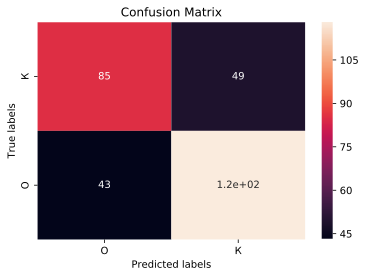

In [8]:
#Создание модели КNN
from sklearn.neighbors import KNeighborsClassifier
print("КNN\n")
#----------------------------------------------------------------------
#GridSearchCV
tuned_parameters= list(range(1,30))
knnModel = KNeighborsClassifier()
grid = GridSearchCV(knnModel, param_grid={'n_neighbors': tuned_parameters},cv=5)
grid.fit(normalized_train_dataset, train_target)

best_cv_err = 1 - grid.best_score_
best_n_neighbors = grid.best_estimator_.n_neighbors
print (best_cv_err, best_n_neighbors,"\n")
#----------------------------------------------------------------------
#Обучение модели с оптимальными параметрами

knnModel = KNeighborsClassifier(n_neighbors=best_n_neighbors)
knnModel.fit(normalized_train_dataset, train_target)

expected = test_target
predicted = knnModel.predict(normalized_test_dataset)

#---------------------------------------------------------------------
#Отрисовка confusion_matrix
from sklearn.metrics import confusion_matrix

cm = metrics.confusion_matrix(expected, predicted)
print(cm)
import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax);
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['О', 'К']); 
ax.yaxis.set_ticklabels(['К','О']);
#--------------------------------------------------------------------
#Результаты
f1ScoreWeighted=f1_score(test_target, predicted, average='weighted')
print("f1ScoreWeighted=",f1ScoreWeighted)

f1ScoreMacro=f1_score(test_target, predicted, average='macro')
print("f1ScoreMacro=",f1ScoreMacro)
      
f1ScoreBinary=f1_score(test_target, predicted, average='binary')
print("f1ScoreBinary=",f1ScoreBinary)

Score.append(f1ScoreBinary)
NameModel.append("knnModel")
save,name=saveModel(Score[2],path,NameModel[2])
if save==True:
    with open(name, 'wb') as fid:
        pickle.dump(knnModel, fid)

Наивный Байес

[[85 49]
 [77 84]]
f1ScoreWeighted= 0.5727439303710491
f1ScoreMacro= 0.5728764478764479
f1ScoreBinary= 0.5714285714285715


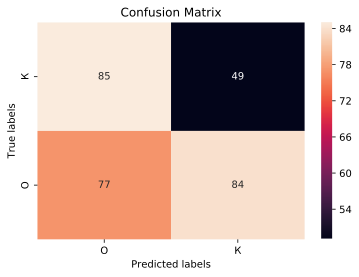

In [9]:
#Использование модели Наивный Байес
print("Наивный Байес\n")
from sklearn.naive_bayes import GaussianNB
#----------------------------------------------------------------------

nbModel = GaussianNB()
nbModel.fit(normalized_train_dataset, train_target)

expected = test_target
predicted = nbModel.predict(normalized_test_dataset)

#---------------------------------------------------------------------
#Отрисовка confusion_matrix
from sklearn.metrics import confusion_matrix

cm = metrics.confusion_matrix(expected, predicted)
print(cm)
import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['О', 'К']); 
ax.yaxis.set_ticklabels(['К','О']);
#--------------------------------------------------------------------
#Результы
f1ScoreWeighted=f1_score(test_target, predicted, average='weighted')
print("f1ScoreWeighted=",f1ScoreWeighted)

f1ScoreMacro=f1_score(test_target, predicted, average='macro')
print("f1ScoreMacro=",f1ScoreMacro)

f1ScoreBinary=f1_score(test_target, predicted, average='binary')
print("f1ScoreBinary=",f1ScoreBinary)

Score.append(f1ScoreBinary)
NameModel.append("nbModel")
save,name=saveModel(Score[3],path,NameModel[3])
if save==True:
    with open(name, 'wb') as fid:
        pickle.dump(nbModel, fid)

In [10]:
eclf1 = VotingClassifier(estimators=[('nb', nbModel), ('knn', knnModel), 
                                     ('lg', lgModel),('cart', cartModel)], 
                                     voting='hard')
eclf1 = eclf1.fit(normalized_train_dataset, train_target)

eclf2 = VotingClassifier(estimators=[('nb', nbModel), ('knn', knnModel),
                                     ('lg', lgModel),('cart', cartModel)],
                                     voting='soft')
eclf2 = eclf2.fit(normalized_train_dataset, train_target)

eclf3 = VotingClassifier(estimators=[('nb', nbModel), ('knn', knnModel), 
                                     ('lg', lgModel),('cart', cartModel)],
                                    voting='soft', flatten_transform=True)
eclf3 = eclf3.fit(normalized_train_dataset, train_target)

print(eclf1.score( normalized_train_dataset, train_target))
print(eclf2.score( normalized_train_dataset, train_target))
print(eclf3.score( normalized_train_dataset, train_target),'\n')

print(eclf1.score( normalized_test_dataset, test_target))
print(eclf2.score( normalized_test_dataset, test_target))
print(eclf3.score( normalized_test_dataset, test_target),'\n')

NameModel.append("VotingClassifier")
Score.append(max(eclf1.score( normalized_test_dataset, test_target),
                           eclf2.score( normalized_test_dataset, test_target),
                           eclf3.score( normalized_test_dataset, test_target)))

0.7551020408163265
0.7638483965014577
0.7653061224489796 

0.6915254237288135
0.6474576271186441
0.6610169491525424 



In [11]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

#GradientBoostingClassifier

learning_rates=np.arange(0.05, 1.05, 0.05)

for learning_rate in learning_rates:
    gb = GradientBoostingClassifier(n_estimators=20, 
                                    learning_rate = learning_rate,
                                    max_features=2, 
                                    max_depth = 2,
                                    random_state = 0)
    gb.fit( normalized_train_dataset, train_target)
    
    print("Learning rate: ", learning_rate,"\n")
    print("Accuracy score (training): {0:.3f}".format(gb.score(normalized_test_dataset, test_target)))    

Learning rate:  0.05 

Accuracy score (training): 0.671
Learning rate:  0.1 

Accuracy score (training): 0.641
Learning rate:  0.15000000000000002 

Accuracy score (training): 0.661
Learning rate:  0.2 

Accuracy score (training): 0.668
Learning rate:  0.25 

Accuracy score (training): 0.685
Learning rate:  0.3 

Accuracy score (training): 0.705
Learning rate:  0.35000000000000003 

Accuracy score (training): 0.708
Learning rate:  0.4 

Accuracy score (training): 0.681
Learning rate:  0.45 

Accuracy score (training): 0.668
Learning rate:  0.5 

Accuracy score (training): 0.664
Learning rate:  0.55 

Accuracy score (training): 0.681
Learning rate:  0.6000000000000001 

Accuracy score (training): 0.688
Learning rate:  0.6500000000000001 

Accuracy score (training): 0.671
Learning rate:  0.7000000000000001 

Accuracy score (training): 0.698
Learning rate:  0.7500000000000001 

Accuracy score (training): 0.698
Learning rate:  0.8 

Accuracy score (training): 0.685
Learning rate:  0.850000

[[85 49]
 [77 84]]
Classification Report
             precision    recall  f1-score   support

          0       0.67      0.66      0.67       134
          1       0.72      0.73      0.72       161

avg / total       0.70      0.70      0.70       295



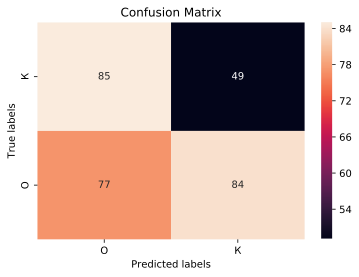

In [12]:
gb = GradientBoostingClassifier(n_estimators=20, learning_rate = 0.75, 
                                max_features=2, max_depth = 2, 
                                random_state = 0)
gb.fit( normalized_train_dataset, train_target)

predictions = gb.predict(normalized_test_dataset)
#---------------------------------------------------------------------
#Отрисовка confusion_matrix
from sklearn.metrics import confusion_matrix

cm = metrics.confusion_matrix(expected, predicted)
print(cm)
import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax) 
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['О', 'К'])
ax.yaxis.set_ticklabels(['К','О'])
#--------------------------------------------------------------------

print("Classification Report")
print(classification_report(test_target, predictions))  

save,name=saveModel(Score[4],path,NameModel[4])
if save==True:
    with open(name, 'wb') as fid:
        pickle.dump(gb, fid)

In [13]:
y_scores_gb = gb.decision_function(normalized_test_dataset)
fpr_gb, tpr_gb, _ = roc_curve(test_target, y_scores_gb)
roc_auc_gb = auc(fpr_gb, tpr_gb)

print("Area under ROC curve = {:0.2f}".format(roc_auc_gb))

Area under ROC curve = 0.77


C:\Users\Admin\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
No handles with labels found to put in legend.


[0.7080745341614908, 0.6883116883116883, 0.7195121951219512, 0.5714285714285715, 0.6915254237288135]
['cartModel', 'lgModel', 'knnModel', 'nbModel', 'VotingClassifier']


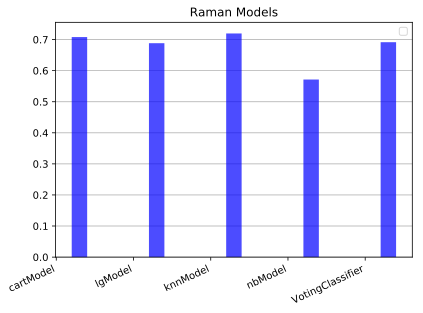

In [16]:
print(Score)
print(NameModel)
from pandas import date_range,Series,DataFrame,read_csv, qcut
from numpy.random import rand

#df2 = pd.DataFrame(a, columns=['NameModel'])
#df2.plot(kind='bar');

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
import csv

dpi = 80
fig = plt.figure(dpi = dpi, figsize = (512 / dpi, 384 / dpi) )
mpl.rcParams.update({'font.size': 10})
plt.title('Raman Models')
ax = plt.axes()
ax.yaxis.grid(True, zorder = 1)
xs = range(len(NameModel))
plt.bar([x + 0.3 for x in xs], Score,
        width = 0.2, color = 'blue', alpha = 0.7,
        zorder = 2)
plt.xticks(xs,NameModel)

fig.autofmt_xdate(rotation = 25)

plt.legend(loc='upper right')
fig.savefig('bars.png')